In [1]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import sklearn as sk
from PIL import Image, ImageOps, ImageDraw

2024-05-24 11:02:25.523449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 11:02:26.794292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the binary file
binary_file = 'games_small.npz'
data = np.load(binary_file, allow_pickle=True)

images = data['images']
images.astype('float32')
labels = data['labels']
label_names = data['label_names']


df = pd.DataFrame({
    'image': list(images),
    'label': labels
})
df['label'] = labels
print(label_names)

['CSGO' 'Fortnite' 'Forza Horizon' 'Genshin impact' 'Minecraft' 'Terraria'
 'Valorant']


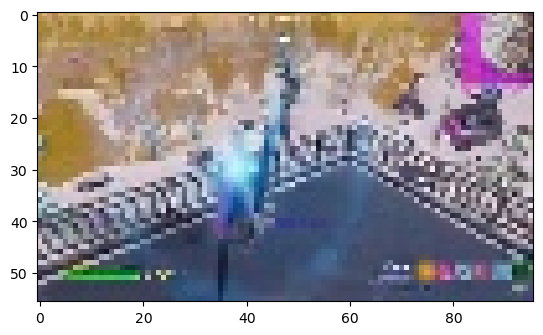

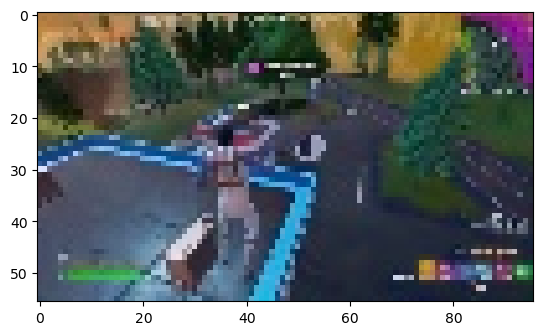

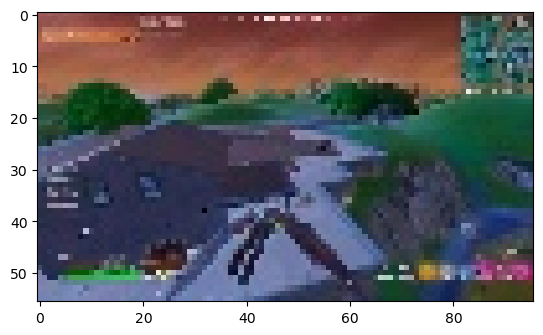

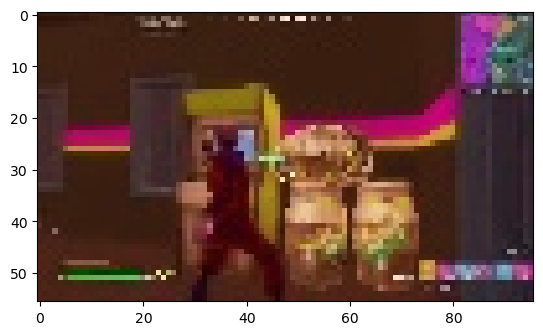

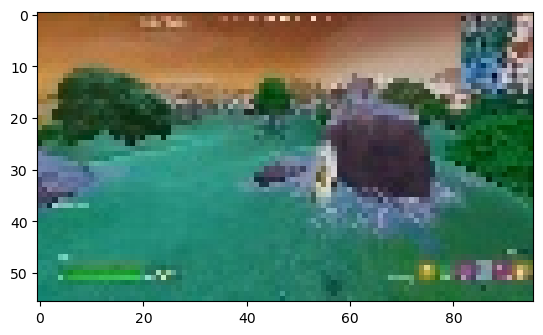

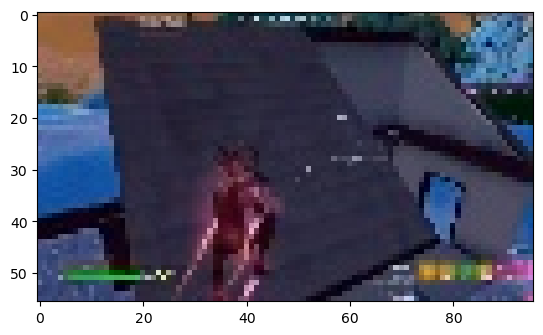

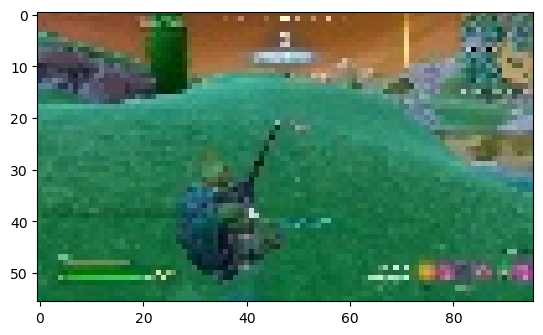

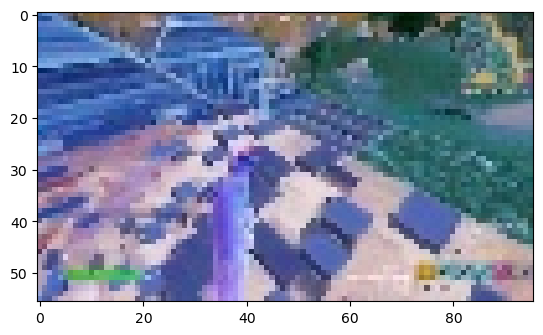

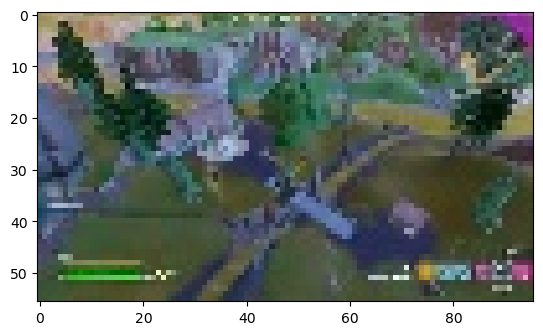

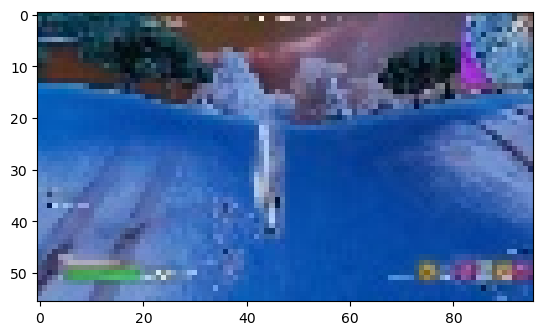

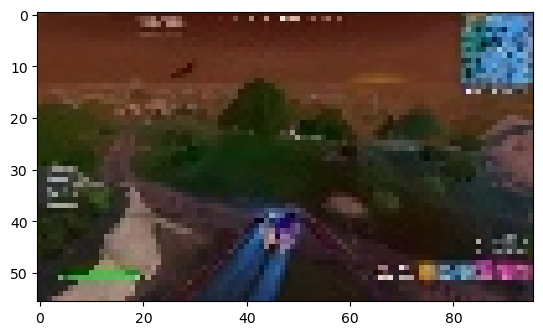

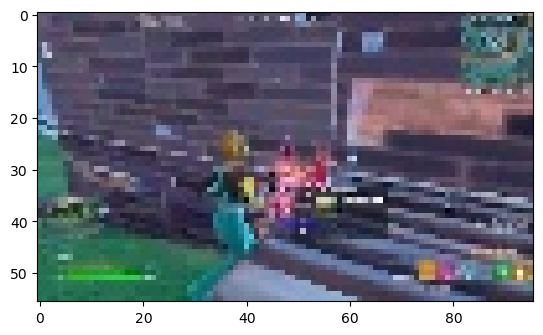

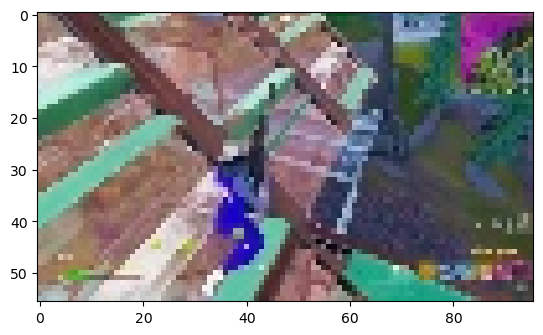

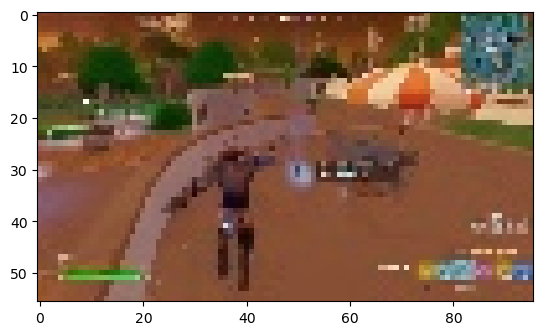

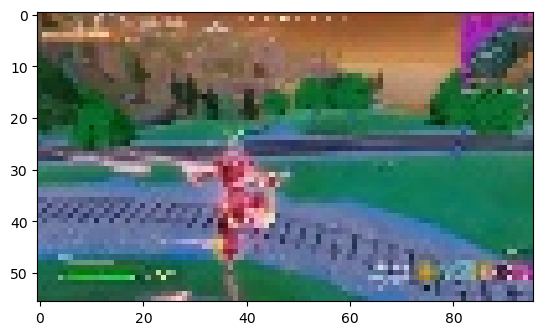

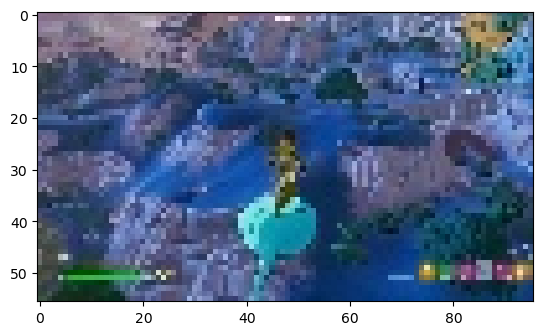

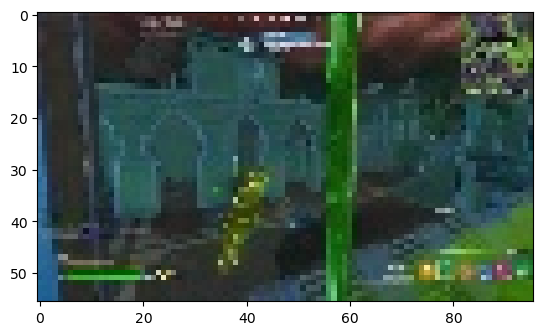

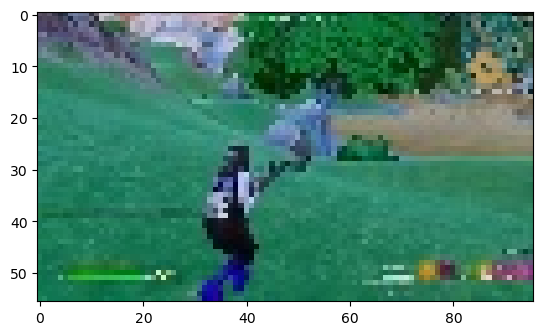

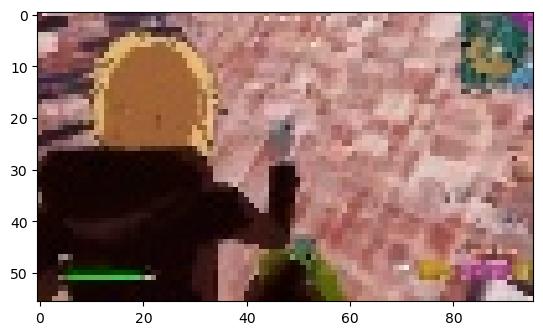

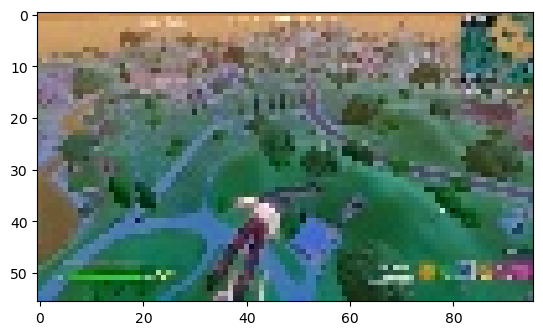

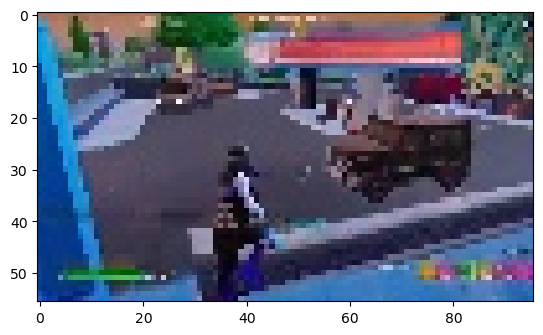

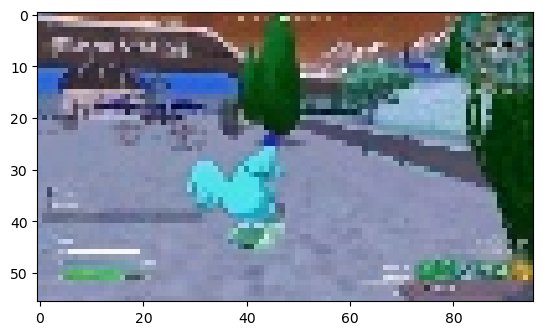

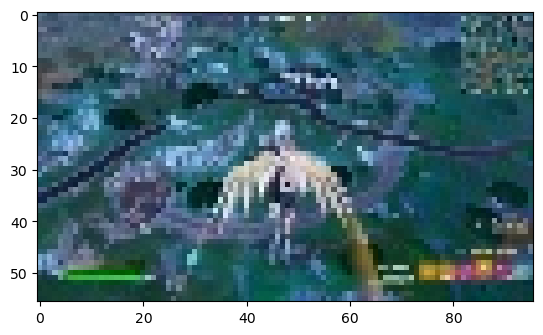

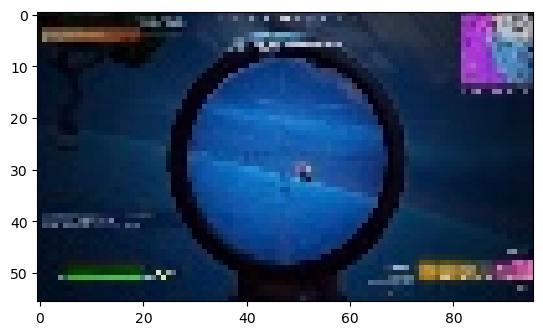

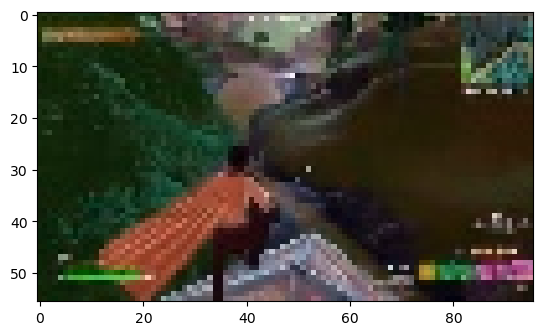

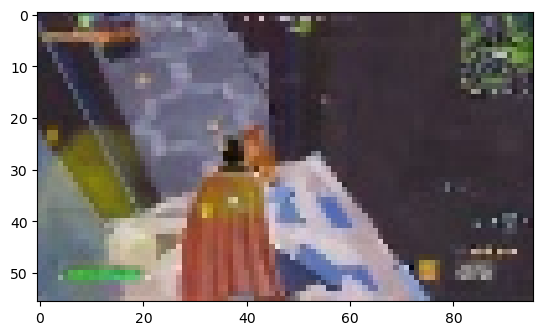

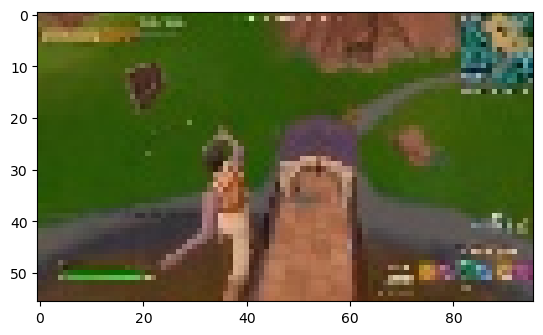

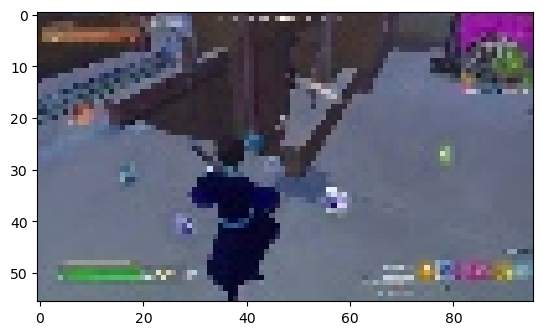

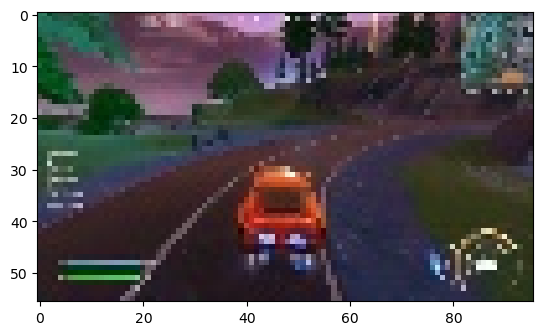

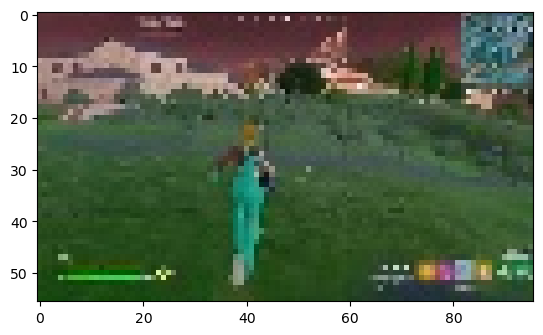

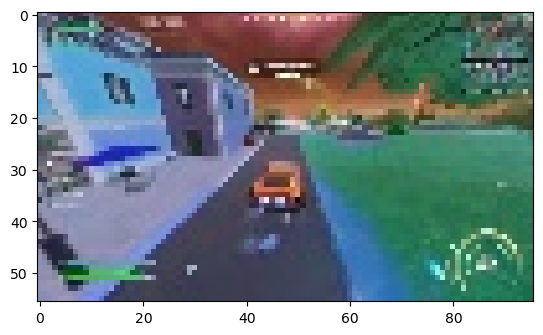

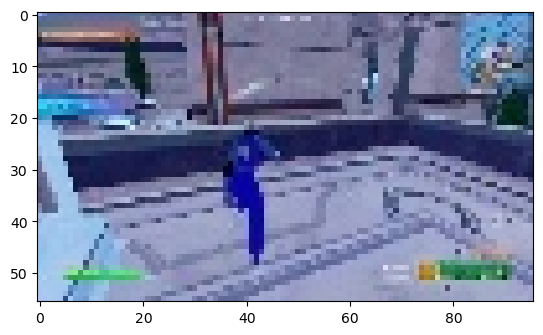

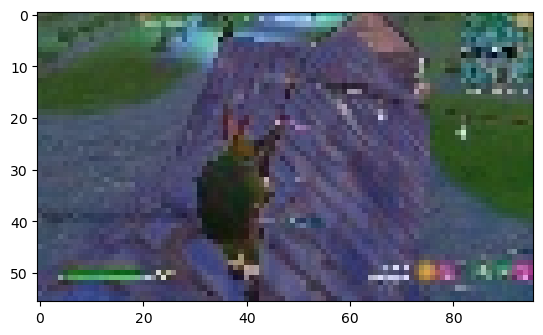

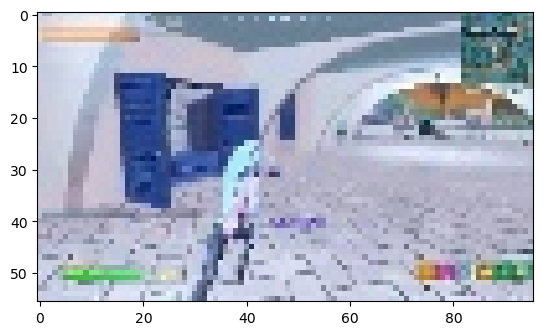

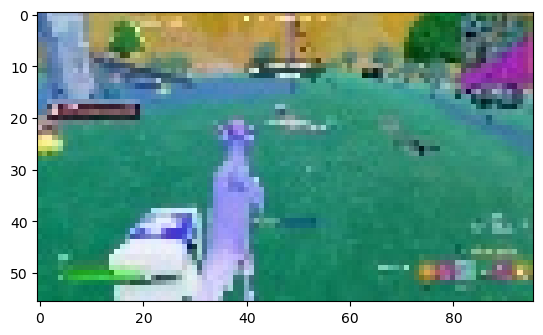

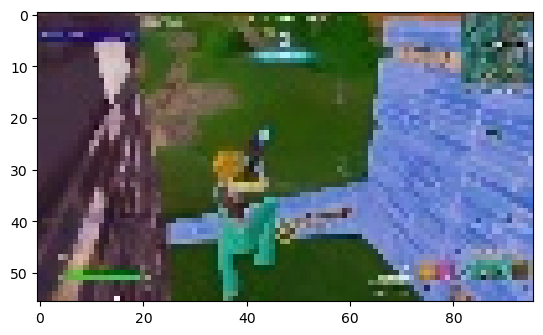

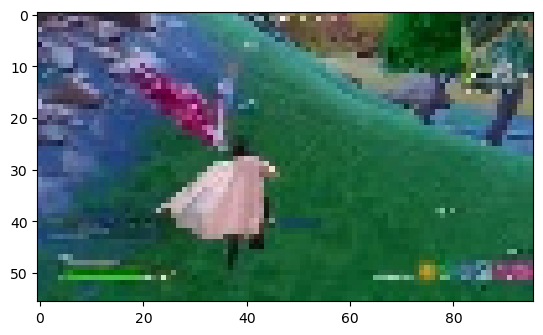

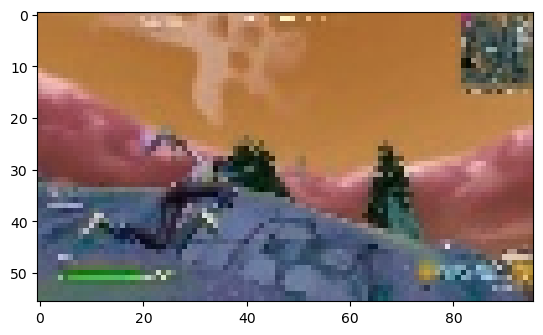

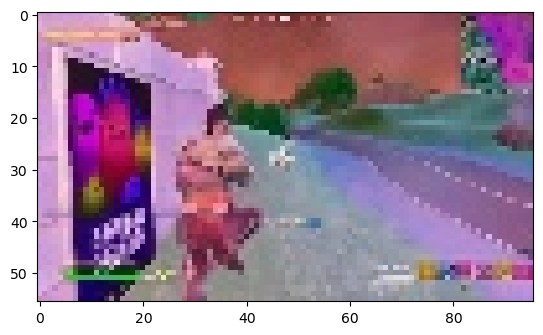

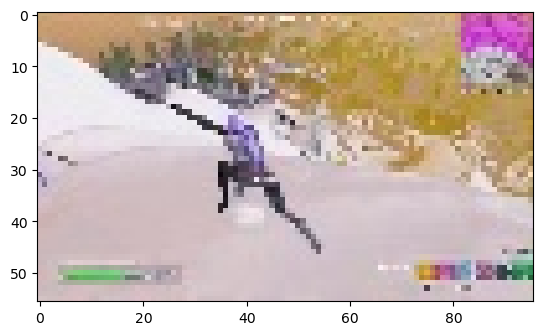

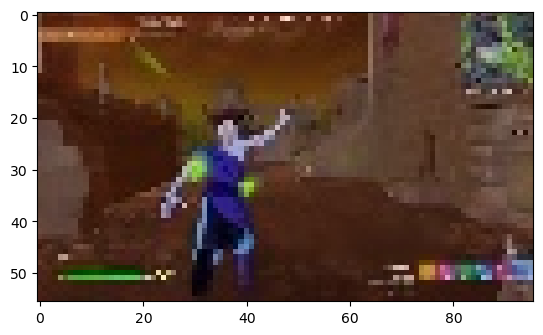

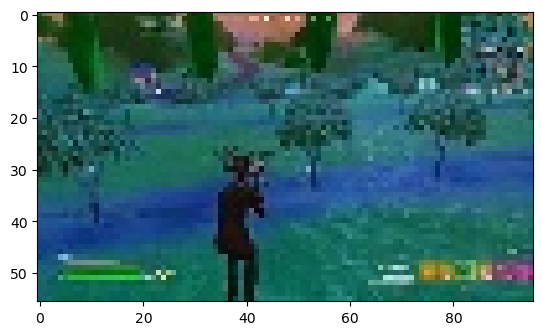

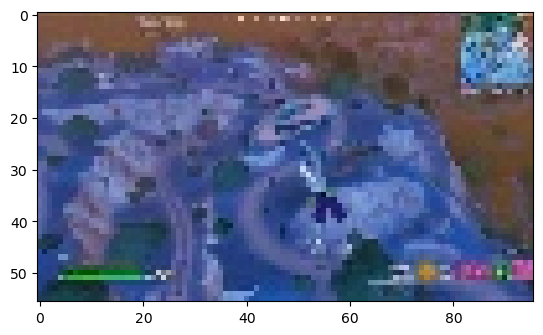

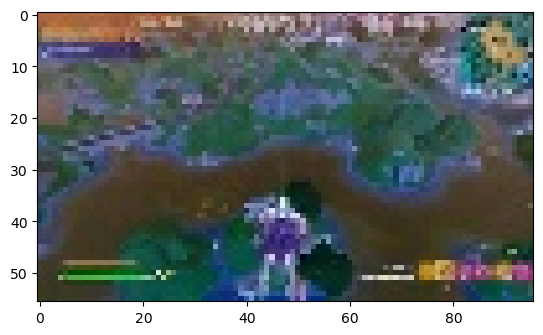

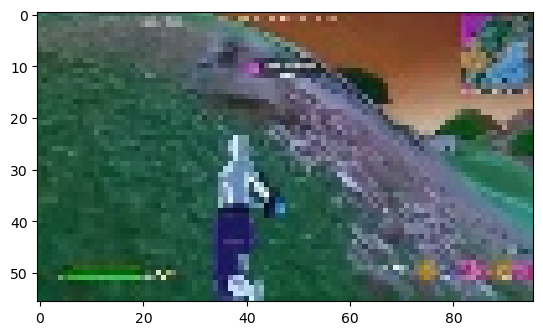

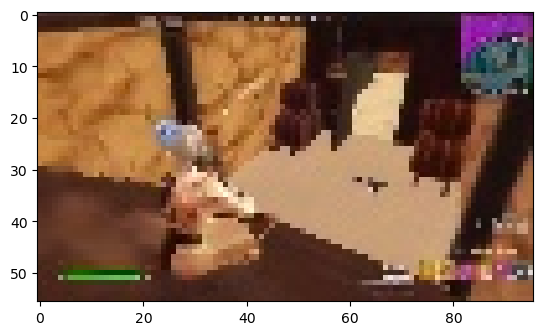

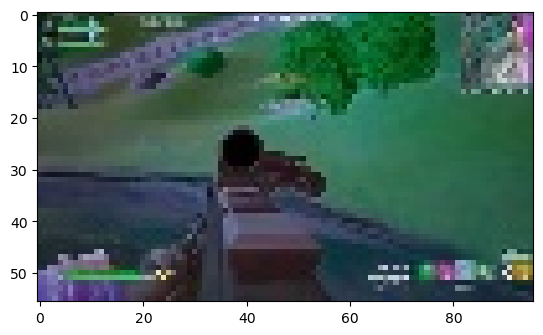

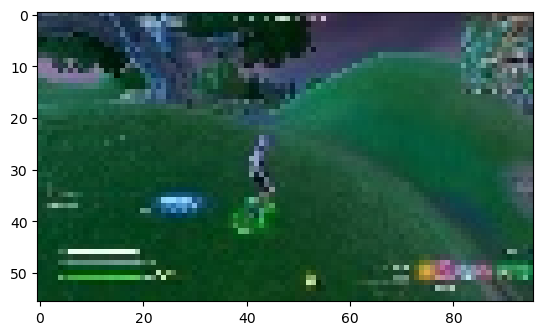

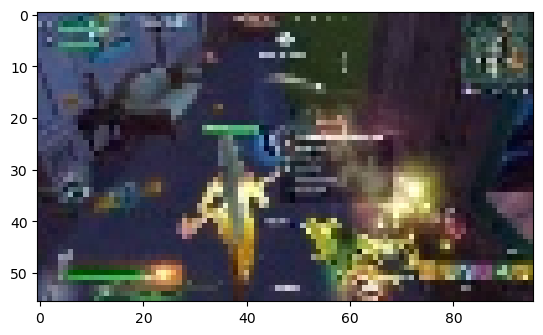

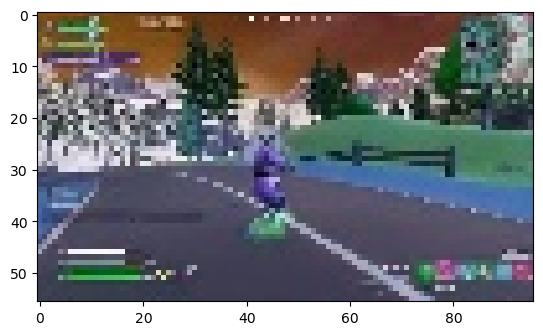

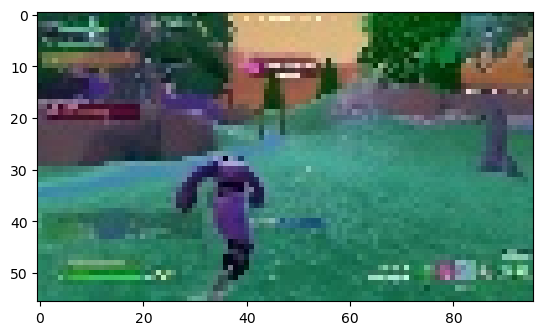

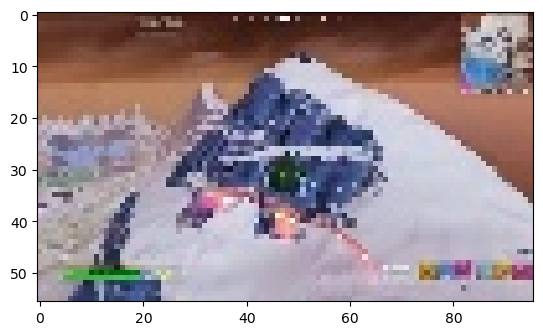

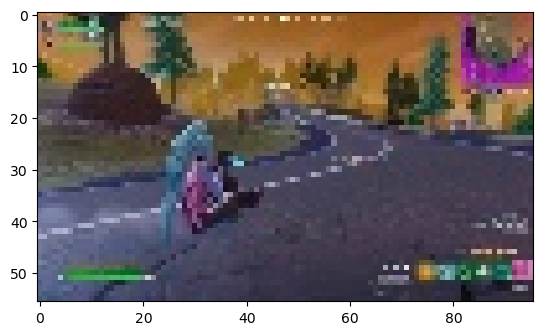

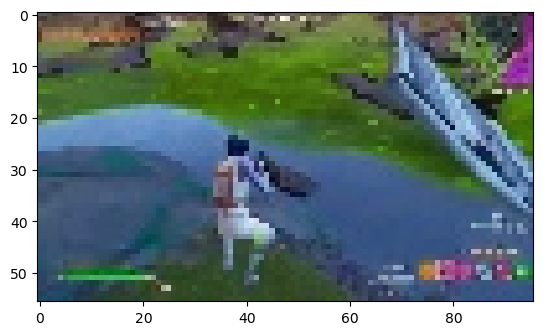

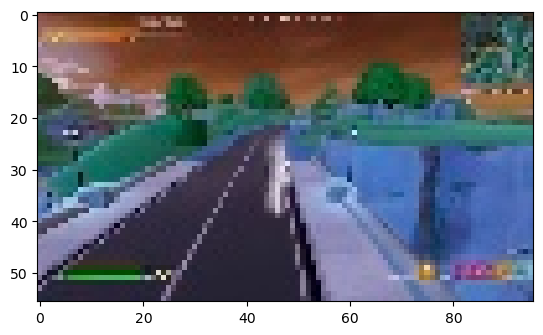

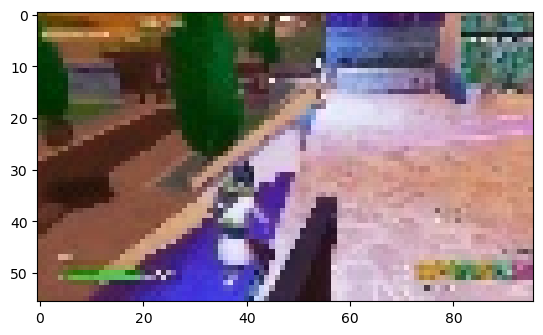

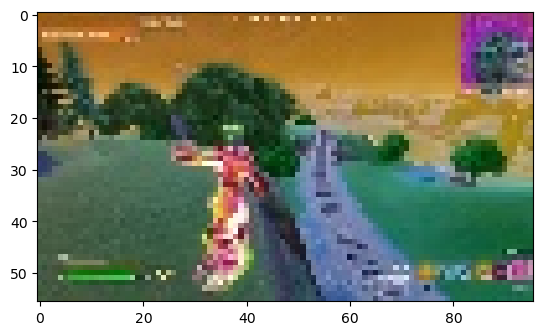

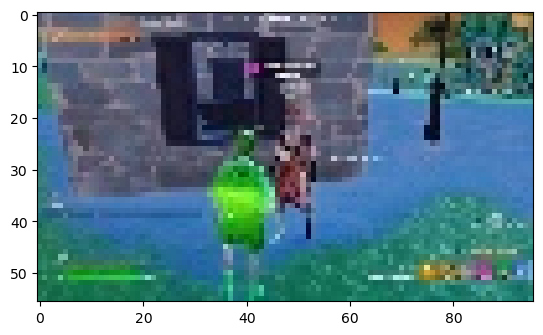

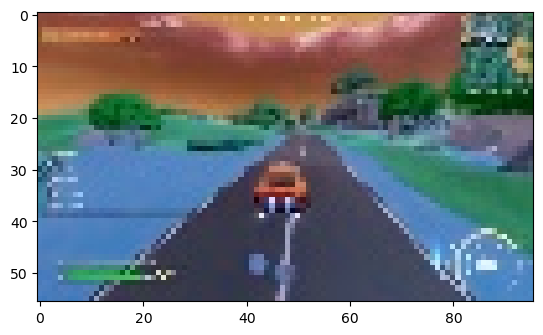

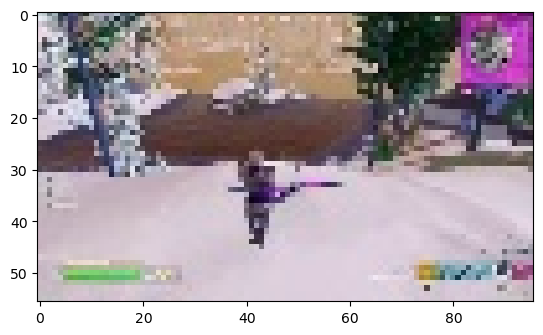

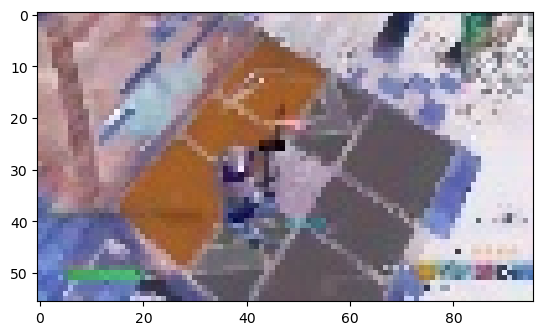

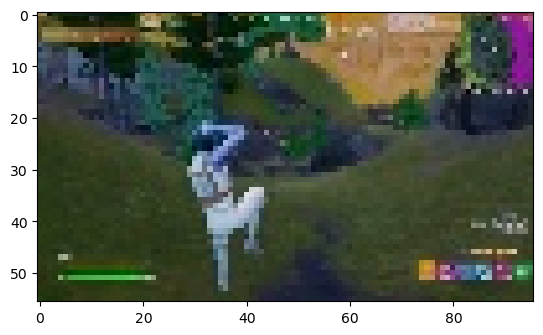

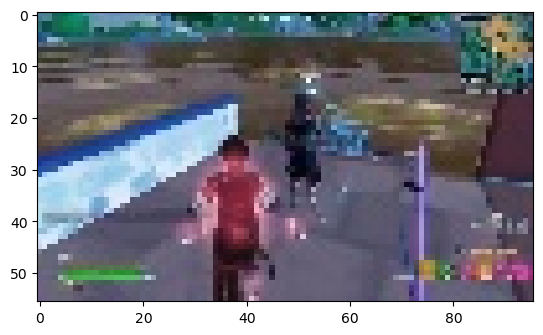

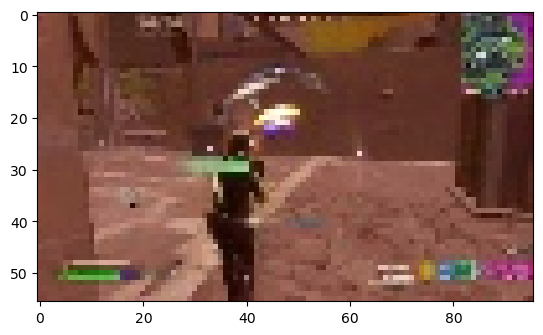

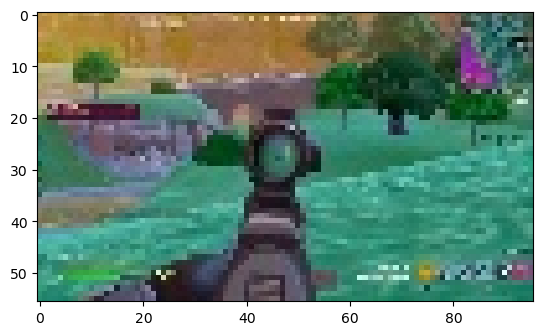

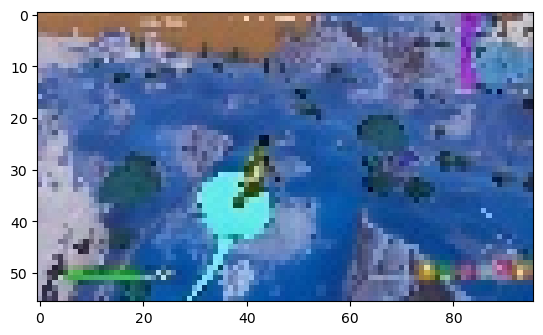

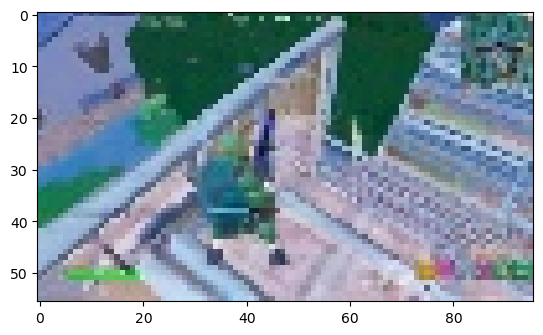

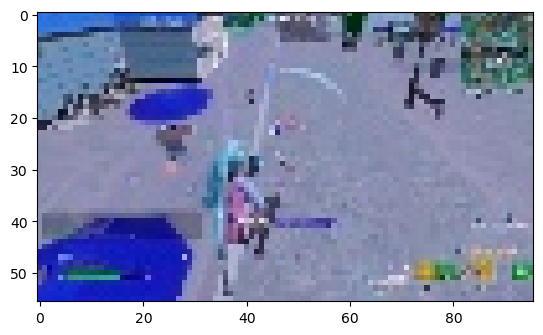

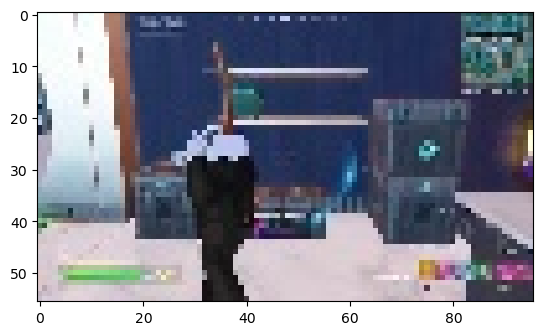

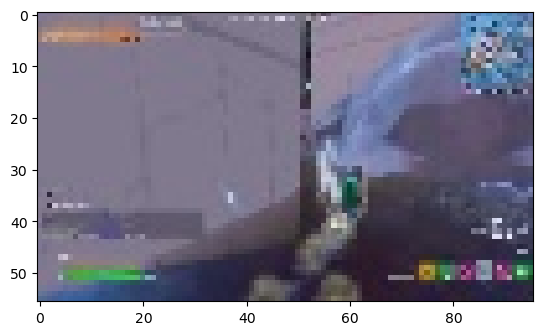

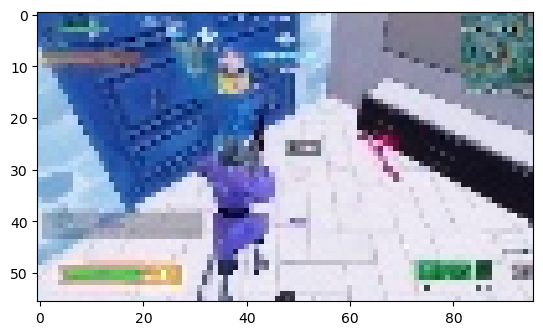

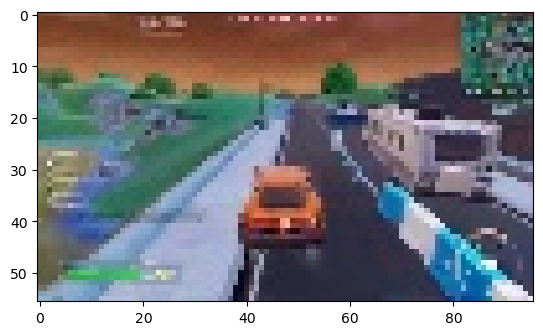

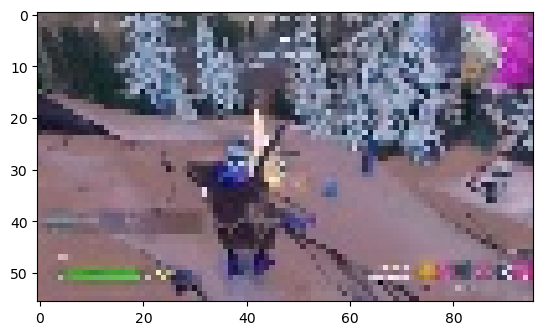

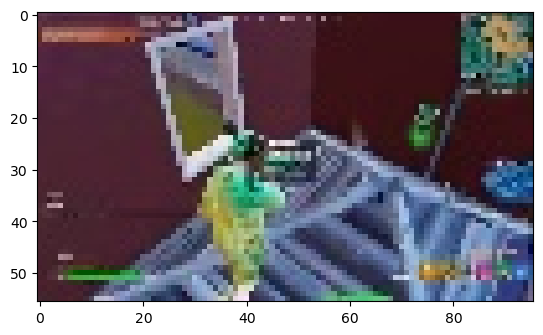

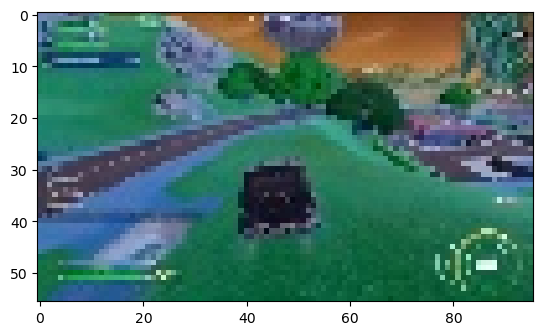

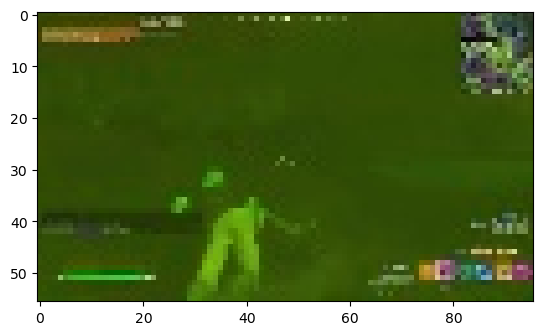

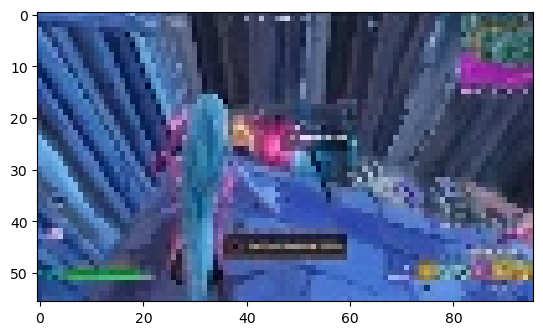

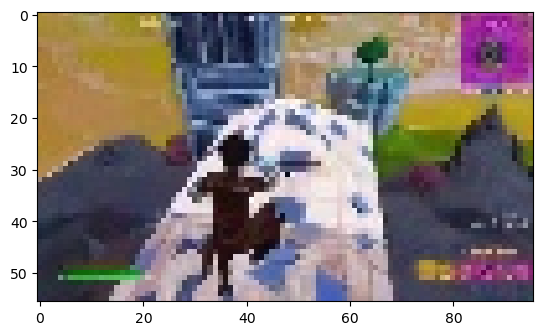

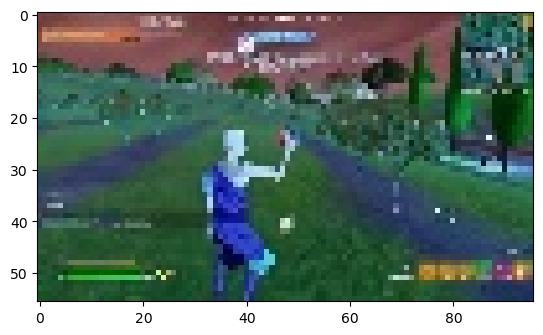

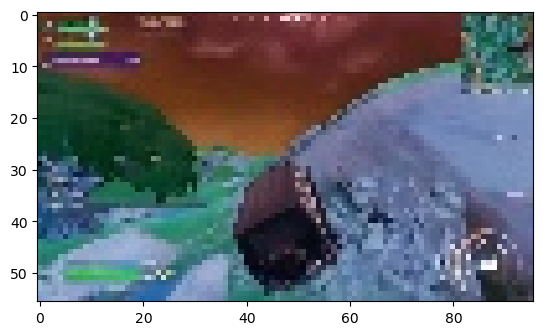

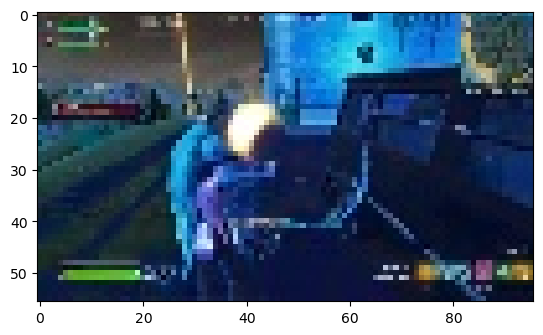

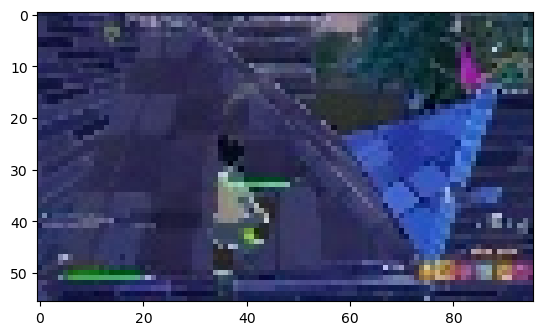

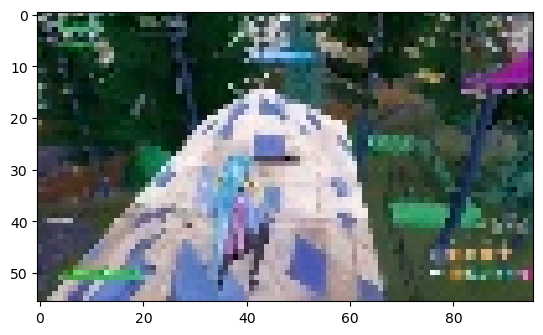

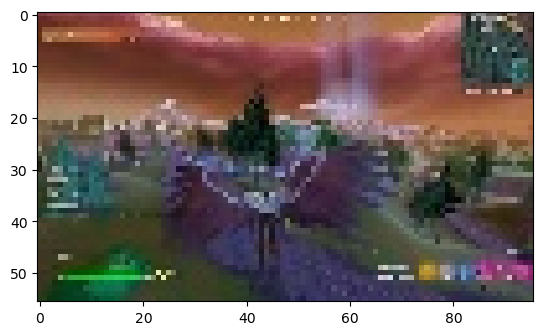

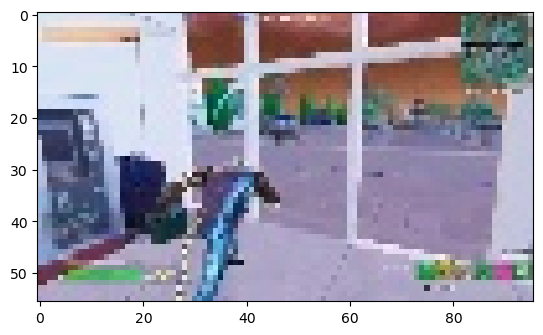

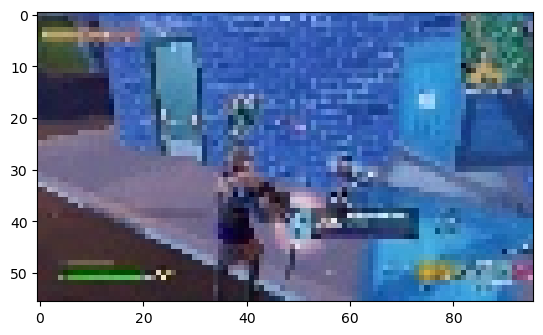

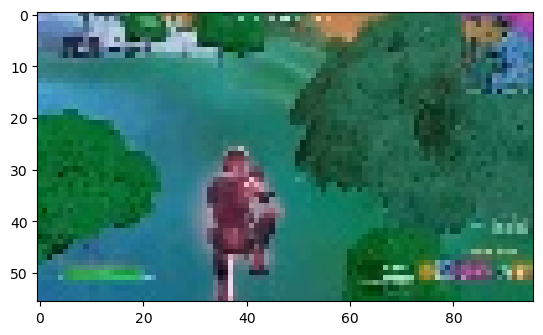

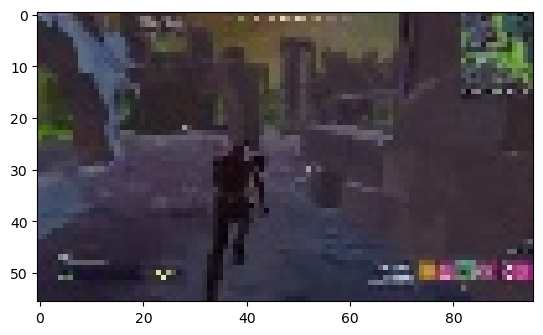

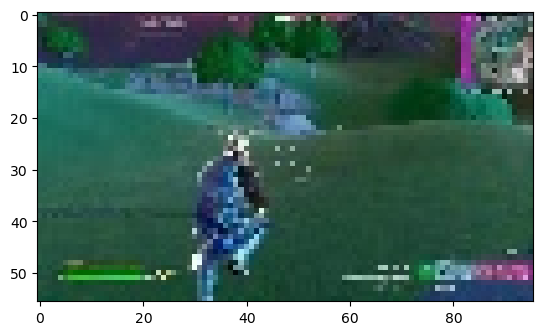

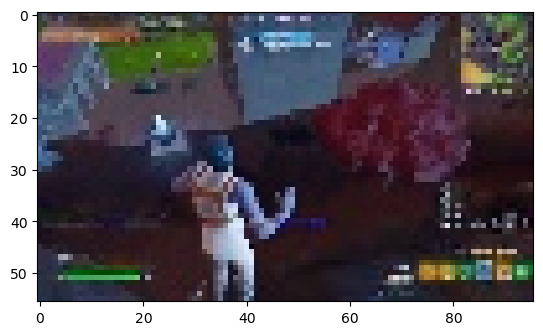

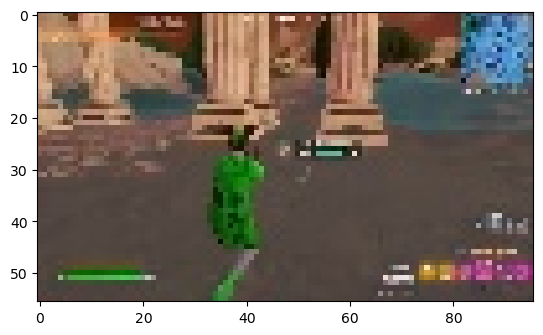

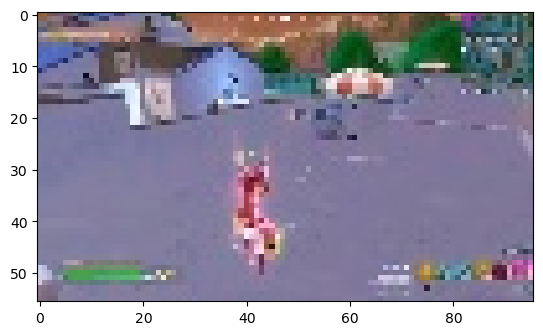

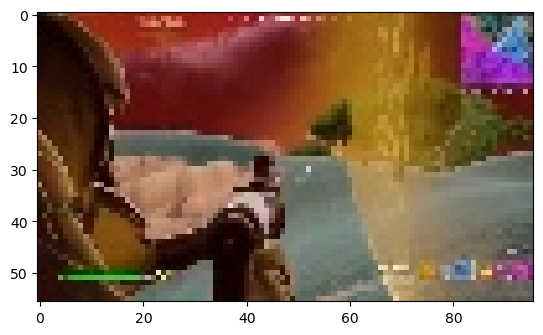

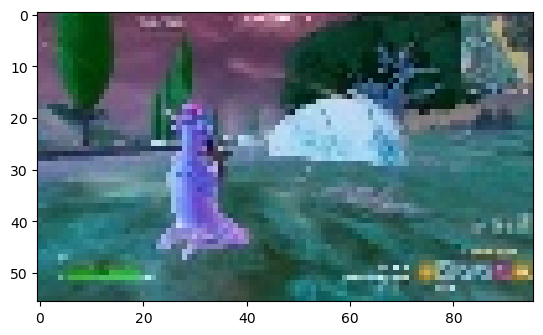

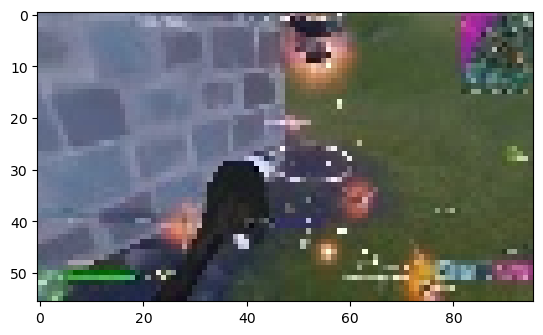

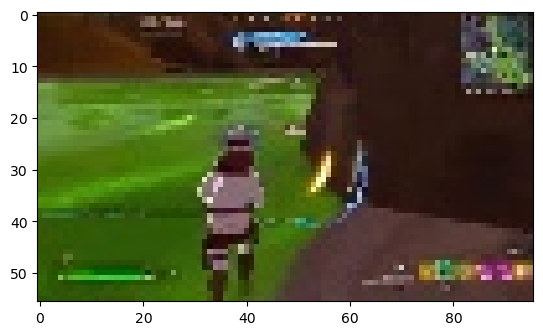

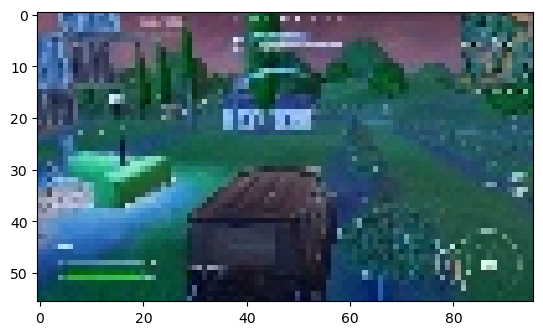

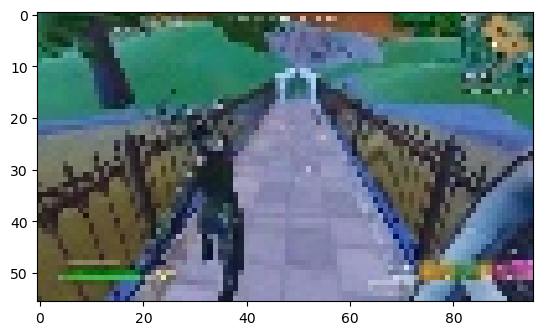

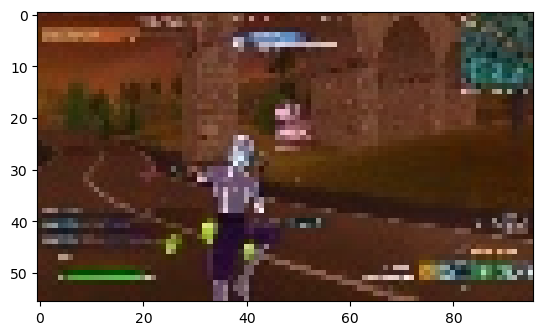

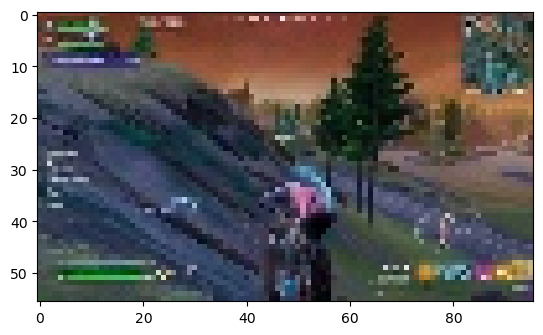

In [7]:
for i in range(100):
    plt.imshow(images[1000+i])
    plt.show()

In [3]:
def sample(images, labels, num_samples_per_class):
    selected_images = []
    selected_labels = []
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        selected_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        selected_images.extend(images[selected_indices])
        selected_labels.extend(labels[selected_indices])
    
    return np.array(selected_images), np.array(selected_labels)

In [4]:
num_samples_per_class = 1000
images, labels = sample(images, labels, num_samples_per_class)

In [5]:
print(len(images))

7000


In [6]:
images[:, :10, :, :] = 0  # First 5 rows
images[:, -10:, :, :] = 0  # Last 5 rows

# Set the first 5 and last 5 columns to (0, 0, 0)
images[:, :, :10, :] = 0  # First 5 columns
images[:, :, -10:, :] = 0  # Last 5 columns

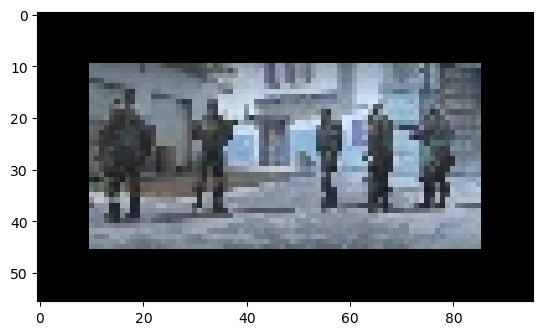

In [8]:
plt.imshow(images[0])

In [10]:
categorical = tf.keras.utils.to_categorical(labels)

In [11]:
X_train, X_test, y_train, y_test =train_test_split(images, categorical, test_size=0.2, random_state=42)

In [15]:
def Cnn_model(input_shape: tuple, num_classes: int):
    model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(images.shape[1], images.shape[2], images.shape[3])),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size: size of each processed batch
    :param int epochs: number of epochs
    """
    callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
    model.fit(x, y, epochs=10, batch_size=64, callbacks=[callback], validation_data=(x_test, y_test))

In [17]:
model = Cnn_model(X_train.shape[1:], 7)

/home/remix375/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1716540726.785884   14161 cuda_executor.cc:1021] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 10:52:06.981168: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries fo

In [18]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10


2024-05-24 10:52:10.288646: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 361267200 exceeds 10% of free system memory.


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2171 - loss: 1.9087

2024-05-24 10:52:23.001334: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90316800 exceeds 10% of free system memory.


175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.2173 - loss: 1.9085 - val_accuracy: 0.3393 - val_loss: 1.7878
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.3652 - loss: 1.7392 - val_accuracy: 0.4550 - val_loss: 1.5170
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.4450 - loss: 1.5107 - val_accuracy: 0.5564 - val_loss: 1.2711
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5151 - loss: 1.3386 - val_accuracy: 0.6371 - val_loss: 1.0943
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6074 - loss: 1.1424 - val_accuracy: 0.6800 - val_loss: 0.9627
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6540 - loss: 1.0101 - val_accuracy: 0.7293 - val_loss: 0.8410
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7044 - loss: 0.8864 - val_accuracy: 0.7264 - val_loss: 0.8158
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.7129 - loss: 0.8303 - val_accurac

In [19]:
def predict(model, x: np.array, labels: list, file_name: str = None) -> np.array:
    """
    Plots the figures for which we want to predict the class alongside
    the predicted probabilities of each class.

    :param model: Keras model
    :param numpy.array x: a few test points to predict
    :param list labels: the list of labels associated with classes 0, ..., 9
    :param str file_name: (optional) filename to save the plot
    :return: the class prediction
    """
    lab = ['CSGO', 'Fortnite', 'Forza Horizon', 'Genshin impact', 'Minecraft', 'Terraria',
 'Valorant']


    y = model.predict(x)
    f, axes = plt.subplots(x.shape[0], 2, figsize=(33, 24))
    for i in range(x.shape[0]):
        axes[i, 0].imshow(x[i])
        axes[i, 1].barh(lab, y[i])
        
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()
    return y

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


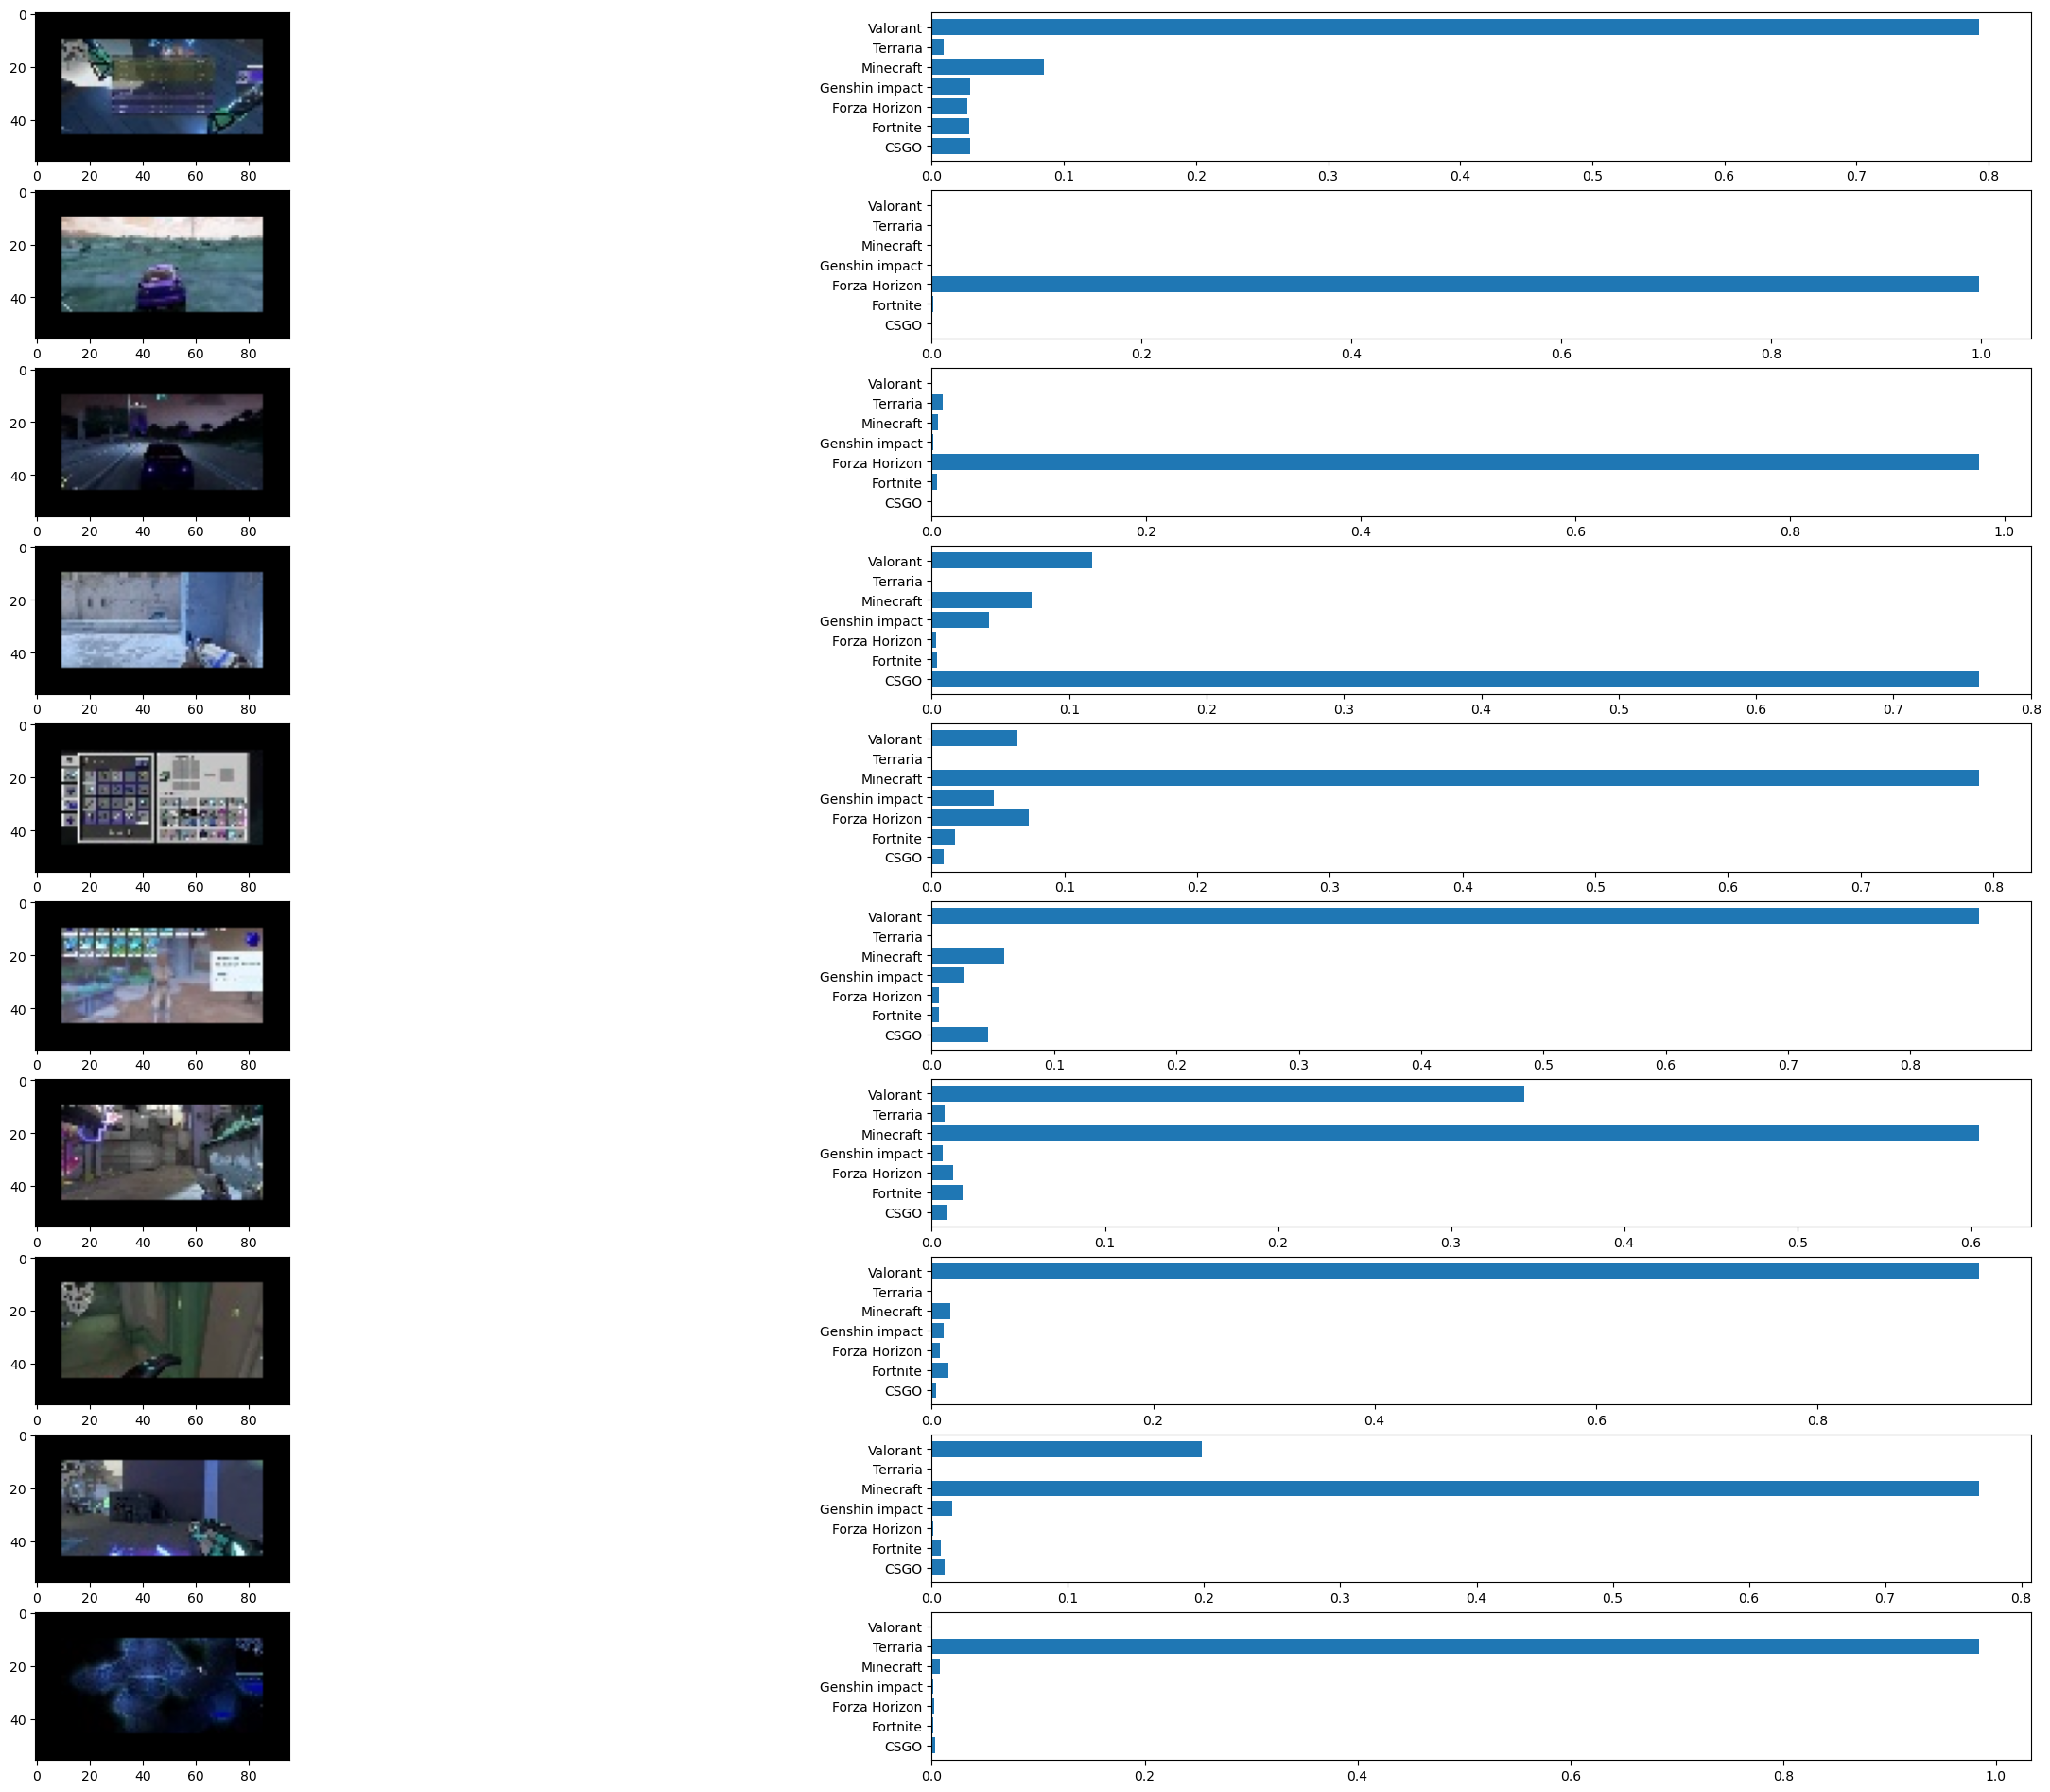

array([[2.89323479e-02, 2.82597505e-02, 2.70165671e-02, 2.91004069e-02,
        8.52018520e-02, 8.97214096e-03, 7.92516947e-01],
       [1.85621888e-04, 1.58973457e-03, 9.97723222e-01, 8.17357723e-05,
        3.31472460e-04, 2.93018584e-05, 5.88504518e-05],
       [8.36751366e-04, 4.77243122e-03, 9.76199150e-01, 1.63887744e-03,
        6.05211360e-03, 1.03754643e-02, 1.25119754e-04],
       [7.62074232e-01, 3.71212675e-03, 3.07903765e-03, 4.16563898e-02,
        7.27403387e-02, 2.41013418e-04, 1.16496734e-01],
       [8.81581288e-03, 1.71694960e-02, 7.29757175e-02, 4.70156707e-02,
        7.88974762e-01, 5.47108357e-04, 6.45014495e-02],
       [4.59091999e-02, 5.97749837e-03, 5.45215653e-03, 2.68621370e-02,
        5.93000315e-02, 6.77368662e-04, 8.55821609e-01],
       [9.16502904e-03, 1.75972339e-02, 1.25423940e-02, 6.12000097e-03,
        6.04814708e-01, 7.28820823e-03, 3.42472494e-01],
       [4.22665710e-03, 1.47369029e-02, 7.28658400e-03, 1.09256338e-02,
        1.66548602e-02, 3

In [20]:
predict(model, X_test[:10], y_test[:10])

In [30]:

def confusion_matrix(model, x_test: np.array, y_test: np.array, labels: list) -> pd.DataFrame:
    """
    Predict on x_test using model
    Use sklearn.metrics.confusion_matrix to get the matrix
    Prettify the result

    :param model: keras model
    :param numpy.array x: a few test points to predict
    :param numpy.array x: true values associated with x_test
    :param list labels: list of names of labels
    """
    lab = ['CSGO', 'Fortnite', 'Forza Horizon', 'Genshin impact', 'Minecraft', 'Terraria',
 'Valorant']

    
    pred = model.predict(x_test)
    df = pd.DataFrame(metrics.confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
    # making the table look fancy
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    df = df.rename({i: lab[i] for i in range(len(lab))}, axis='columns')
    df = df.rename({i: lab[i] for i in range(len(lab))})
    return df

In [31]:
conf_matrix = confusion_matrix(model, X_test, y_test, labels)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [32]:
conf_matrix

CSGO  Fortnite  Forza Horizon  Genshin impact  Minecraft  \
CSGO             154         8              8               5         18   
Fortnite           6       185              3              12          9   
Forza Horizon      1         4            151               1         16   
Genshin impact    13        23             19             106         39   
Minecraft          2         2              2               7        164   
Terraria           0         1              0               1          4   
Valorant           8         4              7               3          8   

                Terraria  Valorant  
CSGO                   1         9  
Fortnite               7         2  
Forza Horizon          1         4  
Genshin impact         2        13  
Minecraft              1         5  
Terraria             205         0  
Valorant               3       153